# Capstone Project - Fuck Around Notebook

- Uses TF24 environment which is not ideal.
- Play with Keras and see if it works
- Explore SpaCy entities
- Find Financial Information
- Linear Model to Predict Score
- Linear Model to Predict Reviews
- K Nearest Neighbors to Group with Similar Books
- Figure out first novel per author (year release date)
- NYT Rankings
- 

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import spacy
import time
import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")

stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/']

def process_text(text, is_spacy=False, keep_stopwords=True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
    text = text.replace("'", '') # Removes apostrophes
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

class TextSet:

    
    def __init__(self, X, y, name=None, is_spacy=False, keep_stopwords=False, random_seed=42, split=.3):
        '''
        Constructs necessary attributes for the Model_Analysis object and automatically processes the X data into Holdout, 
        Train and Test sets ready for vectorization. Also proceses y into labels and sparse OHE matrices, split into Holdout, 
        Train, and Test sets. The Holdout set is 10% of the original test data.
        Parameters:
        ----------
        X : Series or Array
            The text that will be processed in a fashion determined by the other arguments. It will be split into holdout, train, and test batches for testing. 
        y : Series or Array
            The target values for the accompanying texts passed in X. Will be processed with both a label encoder and a one hot encoded sparse matrix. Must be the same dimensions as X.
        name : String
            The name of the TextSet. Used for labeling purposes during analysis.
        is_spacy : Boolean
            Whether or not the text will be processed into a SpaCy doc and will use the SpaCy vectorization method.
        keep_stopwords: Boolean
            Whether or not the processed text will include stop words
        keep_links: Boolean
            If True is passed, Twitter handles and Web URLs will be replaced with dummy words. If False, then the links will be removed completely
        keep_hashtags: Boolean
            If True is passed, the hashtag symbol will be removed, but the rest of the hashtag will remain. If False, then the entire hashtag will be removed.
        random_seed: int
            The random state used for partitioning data
        split: float
            The size of the test set when splitting data into train and test
        '''

        self.X = X
        self.y = y
        self.name = name
        self.is_spacy = is_spacy
        self.keep_stopwords = keep_stopwords
        self.random_seed = random_seed
        self.split = split
        self.process_data()
            
    def process_data(self):
        '''
        Takes X and y and tokenizes the text based on the methods determined by the class's parameters. 
        The data is then split into a 10% holdout group, train, and test groups. The target y variable is 
        processed into labels and one hot encoded sparse matricies.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        text : List
            A list of all processed tokens in the X column
        X_holdout_tokens : List
            Tokenized list of the X holdout group
        X_train_tokens : List
            Tokenized list of the X train group
        X_test_tokens : List
            Tokenized list of the X test group
        y_holdout_ohe : Array
            A sparse matrix of the y holdout group
        y_holdout_l : Array
            A 1D labeled array of the y train group
        y_train_ohe : Array
            A sparse matrix of the y train group
        y_train_l : Array
            A 1D labeled array of the y train group
        y_test_ohe : Array
            A sparse matrix of the y test group
        y_test_l : Array
            A 1D labeled array of the y test group
        y_ohe : OneHotEncoder
            The one hot encoder used to transform y values into sparse matricies
        y_labeler : LabelEncoder
            The label encoder used to transform the y values into the labels fo testing
        process_time 
        : int
            Amount of time in seconds for text to process
        '''
        start_time = time.time()
        
        self.tokens = [process_text(text, 
                                    is_spacy=self.is_spacy, 
                                    keep_stopwords=self.keep_stopwords) for text in self.X]
        
        
        X_processed, self.X_holdout_tokens, y_processed, self.y_holdout = train_test_split(self.tokens, 
                                                                              self.y, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=.1)
        
        self.X_train_tokens, self.X_test_tokens, self.y_train, self.y_test = train_test_split(X_processed, 
                                                                              y_processed, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=self.split)
        
        if self.is_spacy == True:
            token_list = []
            for doc in self.tokens:
                token_list.append([token.text for token in doc])
            self.tokens = token_list
            
        self.text = [' '.join(x) for x in self.tokens]
        
        encoder = OneHotEncoder()
        self.y_train_ohe = encoder.fit_transform(np.array(self.y_train).reshape(-1,1))
        self.y_test_ohe = encoder.transform(np.array(self.y_test).reshape(-1,1))
        self.y_holdout_ohe = encoder.transform(np.array(self.y_holdout).reshape(-1,1))
        self.y_ohe = encoder
        
        labeler = LabelEncoder()
        self.y_train_l = labeler.fit_transform(self.y_train)
        self.y_test_l = labeler.transform(self.y_test)
        self.y_holdout_l = labeler.transform(self.y_holdout)
        self.y_labeler = labeler
        
        self.y_train_ohe = self.y_train_ohe.toarray()
        self.y_test_ohe = self.y_test_ohe.toarray()
        self.y_holdout_ohe = self.y_holdout_ohe.toarray()
        self.process_time = time.time() - start_time
        
        print("--- %s seconds ---" % (self.process_time))
        
        
    def word_cloud(self):
        
        '''
        Visualizes the entire corpus of X into a frequency wordcloud
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        wordcloud : WordCloud
            A visualization of the wordcloud on a (6,6) graph
        '''

        words = ' '.join(self.text)

        self.wordcloud = WordCloud(width = 600, height = 600,
                        background_color ='white',
                        min_font_size = 10).generate(words)

        # plot the WordCloud image                       
        plt.figure(figsize = (6, 6), facecolor = None)
        plt.imshow(self.wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.title(f'Word Cloud For {self.name}')
        plt.show()
        
    
    def plot_frequency(self, num_words = 50):
        
        '''
        Creates a bar graph of the frequencies of each token in the complete corpus of X
        
        Parameters
        ----------
        
        num_words : int
            Number of words to be displayed
            
        Returns
        -------
        
        Bar Plot : graph
            A bar plot of the most frequent words in the X corpus
        '''
    
        data_concat = []

        for tweet in self.tokens:
            data_concat += tweet

        data_freqdist = FreqDist(data_concat)

        x = []
        y = []

        for token in data_freqdist.most_common(num_words):
            x.append(token[0])
            y.append(token[1])

        plt.figure(figsize=(15, 6))
        plt.bar(x=x, height=y)
        plt.xticks(rotation=45)
        plt.xlabel('Words')
        plt.title(f'{self.name} {num_words} Most Common Words')
        plt.ylabel('Frequency')
        plt.show()
    
    def vectorize(self, method='tf_idf', max_features=300, ngram_range=(1,1)):
        
        '''
        Turns X_train, X_test, and X_holdout into vectors for processing 
        
        Parameters
        ----------
        
        method : String - 'tf_idf' or 'count'
            Method of vectorization if is_spacy is False
        max_features : int
            Number of words to be included in the count or TF-IDF vectorization
        ngram_range : tuple
            Number of words to be considered as paired for tokenization
        
        Returns
        -------
        
        X_train: Array
            A vector representation of X_train tokens
        X_test: Array
            A vector representation of X_test tokens
        X_holdout: Array
            A vector representation of X_holdout tokens
        vectorizer: CountVectorizer or TfidfVectorizer
            The vectorizer used to transform the X data
        
        '''
        
        if self.is_spacy == True:
            self.X_train = np.array([doc.vector for doc in self.X_train_tokens])
            self.X_test = np.array([doc.vector for doc in self.X_test_tokens])
            self.X_holdout = np.array([doc.vector for doc in self.X_holdout_tokens])
        
        else:
            X_train = [' '.join(x) for x in self.X_train_tokens]
            X_test = [' '.join(x) for x in self.X_test_tokens]
            X_holdout = [' '.join(x) for x in self.X_holdout_tokens]
            
            if method == 'tf_idf':
                self.vectorizor = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range)
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()

            elif method == 'count':
                self.vectorizor = CountVectorizer(max_features=max_features, ngram_range=(1,1))
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()
                
        
    def regularize(self):
        
        '''
        Normalizes the X vectors using a StandardScaler. Ideal for usage with neural networks. Must be run after the vectorize function.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        scaler: StandardScaler
            The scaler used to transform X vectors
        X_train_scaled: Array
            The scaled vector of X_train
        X_test_scaled: Array
            The scaled vector of X_test
        X_holdout_scaled: Array
            The scaled vector of X_holdout
        '''
            
        self.scaler = StandardScaler()
            
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_holdout_scaled = self.scaler.transform(self.X_holdout)

class ModelComparison:
    
    def __init__(self, pipeline, data_list, y_format='label', nn=False, name=None):
            '''
            Constructs necessary attributes for the ModelComparison object. If nn is True then y_format will be changed to 'ohe'.
            Parameters:
            ----------
            pipeline : Classifier
                An untrained classification alogorithm for comparing against data. A pipeline is recommended in order to control scaling and imputing, but a regular model can be passed.
            data_list : List
                A list of TextSet objects with X, y train, test and holdout sets already processed and vectorized
            y_format : 'label', 'ohe' or 'raw'
                The format of the y_data. If 'label' is passed, then y_train_l will be used. If 'ohe', then y_train_ohe will be used. Else, y_train tokens will be used.
            nn : Boolean
                Whether or not the pipeline is a neural network
            name : String
                The name of the ModelComparison Object.
            '''
            self.pipeline = pipeline
            self.data_list = data_list
            self.name = name
            self.y_format = y_format
            self.data_names = {j:i for (i, j) in tuple(enumerate([x.name for x in self.data_list]))}
            self.ref_dict = {dataset.name : dataset for dataset in self.data_list}
            self.nn = nn
            
            if self.nn == True:
                self.y_format = 'ohe'
    
    def set_model(self, new_model, y_change=None, nn_change=False):
        '''
        Changes the model used for comparison.
        
        Parameters
        ----------
        
        new_model : Classifier
            An untrained classification alogorithm for comparing against data.
        y_change : 'label', 'ohe', 'raw' or None
            The new configuration of the y variable
        nn_change : Boolean
            Pass True if the new model is a neural network, else pass False
        
        '''
        self.pipeline = new_model
        if y_change != None:
            self.y_format = y_change
        
        if nn_change == True:
            self.nn = nn_change

    def fit_models(self, data=None, batch_size=15, epochs=20):
        
        '''
        Fits the model to each of the datasets and produces data for comparison and visualization.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        batch_size : int
            Size of batches used when training a Neural Network model. Ignored if nn is False.
        epochs : int
            Number of epochs used to train a Neural Network model. Ignored if nn is False.
            
        Returns
        -------
        
        data_dict : dictionary
            A dictionary with keys corresponding to the names of each dataset fit to the model. Contains all predicted y values for each dataset for visualization and comparison.
        score_comparison: dataframe
            A dataframe of scores for each dataframe with the maximum value in each row highlighted
        process_time: int
            Amount of time taken to fit the model to all datasets.
        '''
        
        start_time = time.time()
        self.data_dict = {}
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_dict_train = {
                'label': dataset.y_train_l,
                'ohe': dataset.y_train_ohe,
                'raw': dataset.y_train
                }
            
            y_dict_test = {
                'label': dataset.y_test_l,
                'ohe': dataset.y_test_ohe,
                'raw': dataset.y_test
            }
            
            y_dict_holdout = {
                'label': dataset.y_holdout_l,
                'ohe': dataset.y_holdout_ohe,
                'raw': dataset.y_holdout
            }
            
            y_train = y_dict_train[self.y_format]
            y_test = y_dict_test[self.y_format]
            y_holdout = y_dict_holdout[self.y_format]
            
            if self.nn == True:
                
                model = self.pipeline.fit(dataset.X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(dataset.X_train_scaled, y_train))
                
                y_train_preds = self.pipeline.predict(dataset.X_train_scaled)
                y_test_preds = self.pipeline.predict(dataset.X_test_scaled)
                y_holdout_preds = self.pipeline.predict(dataset.X_holdout_scaled)
                
                hold_val = self.pipeline.evaluate(dataset.X_holdout_scaled, y_holdout)
            
            else:
                model = self.pipeline.fit(dataset.X_train, y_train)
                
                y_train_preds = model.predict(dataset.X_train)
                y_test_preds = model.predict(dataset.X_test)
                y_holdout_preds = model.predict(dataset.X_holdout)
            
            if self.nn==False:
                
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,   
                }
            
            else:
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,
                    'model_history': model.history,
                    'holdout_history': hold_val
                }
        
        if self.nn == False:
            self.calc_scores(data=set_list)
        else:
            self.calc_nn_scores(data=set_list)
        self.process_time = time.time() - start_time
        print("--- %s seconds to process ---" % (self.process_time))
    
    def calc_scores(self, data=None, data_type='test'):
        
        '''
        Calculates all major scores on each dataset for comparison for non neural network datasets. Will return an error if the model is a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        data_type : String - 'test' or 'holdout'
            Determines the values compared in the final score comparison. If 'test', then the test scores will be compared. If 'holdout', then holdout scores will be shown.
        
        Returns
        -------
        
        all_scores : DataFrame
            All train and test scores for all datasets in a single dataframe showing scores for Accuracy, Precision, Recall and F1 Score. All values are calculated using the Macro method.
        score_comparison : DataFrame
            Test scores for each dataset compared in a single dataframe with the top value in each row highlighted.
        '''
        
        df_list = []
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_train = self.data_dict[dataset.name]['y_train']
            y_train_preds = self.data_dict[dataset.name]['y_train_preds']
        
            if data_type == 'test':
                
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            
            elif data_type == 'holdout':
            
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            dictionary = {
                'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
            }
            
            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Train',f'{dataset.name} {title}'])
            
            self.data_dict[dataset.name][f'{data_type} scores'] = df
            df_list.append(df)
        
        self.all_scores = pd.concat(df_list, axis=1)
        
        self.score_comparison = self.all_scores[[x for x in self.all_scores.columns if x.endswith(title)]]
        
        self.score_comparison = self.score_comparison.style.highlight_max(color='lightgreen', axis=1)
        
    def calc_nn_scores(self, data=None):
        
        '''
        Calculates accuracy and loss scores for each dataset if the model is a neural network. Will produce an error if the model is not a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        
        Returns
        -------
        
        score_comparison : DataFrame
            A dataframe comparing the accuracy and loss scores on the holdout data for each dataset
        '''

        df_list = []
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data

        for dataset in set_list:

            hist = self.data_dict[dataset.name]['holdout_history']

            dictionary = {
                'Loss': hist[0],
                'Accuracy': hist[1]
            }

            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Holdout'])

            df_list.append(df)

        self.score_comparison = pd.concat(df_list, axis=1)
            
    def compare_confusion(self, data_type='test', data=None):
        
        '''
        Plots a confusion matrix for either the Test or Holdout data for each dataset. Bear in mind, it will fit the model with all of the datsets again.
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the confusion matrix
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
            
        Returns
        -------
        
        A confusion matrix for each dataset passed in data
        '''
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            X_train = dataset.X_train
            y_train = self.data_dict[dataset.name]['y_train']
            
            self.pipeline.fit(X_train, y_train)
            
            if data_type == 'train':
                X_val = dataset.X_train
                y_val = self.data_dict[dataset.name]['y_train']
            
            elif data_type == 'test':
                X_val = dataset.X_test
                y_val = self.data_dict[dataset.name]['y_test']
                
            elif data_type == 'holdout':
                X_val = dataset.X_holdout
                y_val = self.data_dict[dataset.name]['y_holdout']
        
            plot_confusion_matrix(self.pipeline, X_val, y_val, cmap=plt.cm.Blues)
            plt.title(f'{dataset.name} {title}')
            plt.show()
        
    def plot_roc_curve(self, data_type='test', include_train=True, data=None):
        
        '''
        Plots the ROC curve for the results of the model. If a multi-class model it will return an error
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the ROC Plot
        include_train : Boolean
            If True is passed, the ROC plot will include the training data and the validation data
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plot.
        
        Returns
        -------
        
        A plot of the ROC curve of the train and validation data
        '''
        
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            if data_type == 'test':
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            elif data_type == 'holdout':
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            fpr, tpr, threshold = roc_curve(y_val, y_val_preds)
            plt.plot(fpr, tpr, label=f'{dataset.name} {data_type}', ax=ax)
            
            if include_train == True:
                y_train = self.data_dict[dataset.name]['y_train']
                y_train_preds = self.data_dict[dataset.name]['y_train_preds']
                
                fpr, tpr, threshold = roc_curve(y_train, y_train_preds)
                plt.plot(fpr, tpr, label=f'{dataset.name} train', ax=ax)
                
                
        plt.title(f'ROC Curve for {data_type} data')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        
    def plot_val_history(self, data=None):
        
        '''
        Plots the accuracy and loss curves for both the training and the testing data for a neural network model.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plots.
        
        Returns
        -------
        
        A subplot of the training and validation loss and accuracy values from the fit Neural Network model
        
        '''
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            history = self.data_dict[dataset.name]['model_history']
            fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))
            ax1.plot(history['val_loss'])
            ax1.plot(history['loss'])
            ax1.legend(['val_loss', 'loss'])
            ax1.set_title(f'{dataset.name} Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')

            ax2.plot(history['val_acc'])
            ax2.plot(history['acc'])
            ax2.legend(['val_acc', 'acc'])
            ax2.set_title(f'{dataset.name} Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            plt.show()

In [2]:
def match_fields(df_1_column, df_2_column, reverse=False, verbose=True):
    
    '''
    Matches values in fields from two dataframes and returns lists of the missing and matched values.
    
    Parameters
    ----------
    df_1_column - dataframe column - one of the dataframes used for comparison
    df_2_column - dataframe column - the other dataframe used for comparison
    reverse - bool - reverses the matching. Defaults to false so all values in df_1 will be tested to see if they are in df_2. If true, will reverse that logic.
    
    Returns
    -------
    missing - list - all values missing from the two dataframes
    matched - list - all values found in both dataframe columns

    Examples:
    ---------

    matched, missing = ut.match_fields(df['Column'], df_2['Column'], reverse=False)
    '''
    
    if reverse == False:
    
        names = df_1_column.unique()
        accounts = df_2_column.unique()
    
    else:
        
        names = df_2_column.unique()
        accounts = df_1_column.unique()

    missing = []
    matched = []

    for n in names:
        if n in accounts:
            matched.append(n)
        else:
            missing.append(n)

    if verbose == True:
        print('Matched: ', len(matched))
        print('Missing: ', len(missing))

    return matched, missing

In [3]:
df_aliens = pd.read_csv('data/sf_aliens.csv')

In [4]:
df_alt = pd.read_csv('data/sf_alternate_history.csv')
df_alt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1249 non-null   object 
 1   Original_Book_Title  1249 non-null   object 
 2   Author_Name          1249 non-null   object 
 3   Edition_Language     1248 non-null   object 
 4   Rating_score         1249 non-null   float64
 5   Rating_votes         1249 non-null   int64  
 6   Review_number        1249 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1249 non-null   int64  
 9   Genres               1249 non-null   object 
 10  url                  1249 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [5]:
df_alt_u = pd.read_csv('data/sf_alternate_universe.csv')
df_alt_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1247 non-null   object 
 1   Original_Book_Title  1247 non-null   object 
 2   Author_Name          1247 non-null   object 
 3   Edition_Language     1246 non-null   object 
 4   Rating_score         1247 non-null   float64
 5   Rating_votes         1247 non-null   int64  
 6   Review_number        1247 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1247 non-null   int64  
 9   Genres               1247 non-null   object 
 10  url                  1247 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.3+ KB


In [6]:
df_app = pd.read_csv('data/sf_apocalyptic.csv')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1244 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [7]:
df_cyber = pd.read_csv('data/sf_cyberpunk.csv')
df_cyber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1244 non-null   object 
 1   Original_Book_Title  1244 non-null   object 
 2   Author_Name          1244 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1244 non-null   float64
 5   Rating_votes         1244 non-null   int64  
 6   Review_number        1244 non-null   int64  
 7   Book_Description     1226 non-null   object 
 8   Year_published       1244 non-null   int64  
 9   Genres               1244 non-null   object 
 10  url                  1244 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.0+ KB


In [8]:
df_dys = pd.read_csv('data/sf_dystopia.csv')
df_dys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1242 non-null   object 
 1   Original_Book_Title  1242 non-null   object 
 2   Author_Name          1242 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1242 non-null   float64
 5   Rating_votes         1242 non-null   int64  
 6   Review_number        1242 non-null   int64  
 7   Book_Description     1241 non-null   object 
 8   Year_published       1242 non-null   int64  
 9   Genres               1242 non-null   object 
 10  url                  1242 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 106.9+ KB


In [9]:
df_hard = pd.read_csv('data/sf_hard.csv')
df_hard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1246 non-null   object 
 1   Original_Book_Title  1246 non-null   object 
 2   Author_Name          1246 non-null   object 
 3   Edition_Language     1243 non-null   object 
 4   Rating_score         1246 non-null   float64
 5   Rating_votes         1246 non-null   int64  
 6   Review_number        1246 non-null   int64  
 7   Book_Description     1219 non-null   object 
 8   Year_published       1246 non-null   int64  
 9   Genres               1246 non-null   object 
 10  url                  1246 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.2+ KB


In [10]:
df_mil = pd.read_csv('data/sf_military.csv')
df_mil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1241 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1249 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [11]:
df_rob = pd.read_csv('data/sf_robots.csv')
df_rob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1239 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [12]:
df_space = pd.read_csv('data/sf_space_opera.csv')
df_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1247 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1248 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [13]:
df_steam = pd.read_csv('data/sf_steampunk.csv')
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1250 non-null   object 
 1   Original_Book_Title  1250 non-null   object 
 2   Author_Name          1250 non-null   object 
 3   Edition_Language     1249 non-null   object 
 4   Rating_score         1250 non-null   float64
 5   Rating_votes         1250 non-null   int64  
 6   Review_number        1250 non-null   int64  
 7   Book_Description     1246 non-null   object 
 8   Year_published       1250 non-null   int64  
 9   Genres               1250 non-null   object 
 10  url                  1250 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.5+ KB


In [14]:
df_time = pd.read_csv('data/sf_time_travel.csv')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           1248 non-null   object 
 1   Original_Book_Title  1248 non-null   object 
 2   Author_Name          1248 non-null   object 
 3   Edition_Language     1244 non-null   object 
 4   Rating_score         1248 non-null   float64
 5   Rating_votes         1248 non-null   int64  
 6   Review_number        1248 non-null   int64  
 7   Book_Description     1247 non-null   object 
 8   Year_published       1248 non-null   int64  
 9   Genres               1248 non-null   object 
 10  url                  1248 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 107.4+ KB


In [15]:
df_aliens.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Obsidian,Obsidian,Jennifer L. Armentrout,English,4.17,236780,18161,Starting over sucks.When we moved to West Virg...,2011,"{'Young Adult': 3439, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/12578077-o...
1,Onyx,Onyx,Jennifer L. Armentrout,English,4.27,153429,10497,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,2012,"{'Young Adult': 2271, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13047090-onyx
2,The 5th Wave,The 5th Wave,Rick Yancey,English,4.03,400600,29990,"After the 1st wave, only darkness remains. Aft...",2013,"{'Young Adult': 5436, 'Science Fiction': 3327,...",https://www.goodreads.com/book/show/16101128-t...
3,The Host,The Host,Stephenie Meyer,English,3.84,915026,41673,Melanie Stryder refuses to fade away. The eart...,2008,"{'Young Adult': 4529, 'Science Fiction': 4285,...",https://www.goodreads.com/book/show/1656001.Th...
4,Opal,Opal,Jennifer L. Armentrout,None,4.27,129006,9463,No one is like Daemon Black.When he set out to...,2012,"{'Young Adult': 1855, 'Fantasy (Paranormal) ':...",https://www.goodreads.com/book/show/13362536-opal


In [16]:
df_alt.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Man in the High Castle,The Man in the High Castle,Philip K. Dick,English,3.62,180593,11895,It's America in 1962. Slavery is legal once ag...,1962,"{'Science Fiction': 4175, 'Fiction': 3446, 'Sc...",https://www.goodreads.com/book/show/216363.The...
1,His Majesty's Dragon,His Majesty's Dragon,Naomi Novik,English,4.03,83308,6588,Aerial combat brings a thrilling new dimension...,2006,"{'Fantasy': 7710, 'Fantasy (Dragons) ': 1350, ...",https://www.goodreads.com/book/show/28876.His_...
2,Leviathan,Leviathan,Scott Westerfeld,English,3.90,88293,7052,"Prince Aleksander, would-be heir to the Austro...",2009,"{'Science Fiction (Steampunk) ': 3334, 'Young ...",https://www.goodreads.com/book/show/6050678-le...
3,Jonathan Strange & Mr Norrell,Jonathan Strange & Mr Norrell,Susanna Clarke,English,3.82,206919,14397,"Sophisticated, witty, and ingeniously convinci...",2004,"{'Fantasy': 11071, 'Fiction': 3752, 'Historica...",https://www.goodreads.com/book/show/14201.Jona...
4,The Yiddish Policemen's Union,The Yiddish Policemen's Union,Michael Chabon,English,3.71,70984,6992,"For sixty years, Jewish refugees and their des...",2007,"{'Fiction': 2240, 'Mystery': 919, 'Science Fic...",https://www.goodreads.com/book/show/16703.The_...


In [17]:
df_alt_u.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Golden Compass,Northern Lights,Philip Pullman,English,3.99,1319185,23073,"Lyra is rushing to the cold, far North, where ...",1995,"{'Fantasy': 25101, 'Young Adult': 7903, 'Ficti...",https://www.goodreads.com/book/show/119322.The...
1,The Subtle Knife,The Subtle Knife,Philip Pullman,English,4.13,380713,10386,She had asked: What is he? A friend or an enem...,1997,"{'Fantasy': 15001, 'Young Adult': 4852, 'Ficti...",https://www.goodreads.com/book/show/41637836-t...
2,The Amber Spyglass,The Amber Spyglass,Philip Pullman,English,4.08,310788,10747,"Will is the bearer of the knife. Now, accompan...",2000,"{'Fantasy': 13544, 'Young Adult': 4410, 'Ficti...",https://www.goodreads.com/book/show/18122.The_...
3,A Darker Shade of Magic,A Darker Shade of Magic,V.E. Schwab,English,4.06,217080,27707,Kell is one of the last Antari—magicians with ...,2015,"{'Fantasy': 16223, 'Young Adult': 2309, 'Ficti...",https://www.goodreads.com/book/show/22055262-a...
4,His Majesty's Dragon,His Majesty's Dragon,Naomi Novik,English,4.03,83308,6588,Aerial combat brings a thrilling new dimension...,2006,"{'Fantasy': 7710, 'Fantasy (Dragons) ': 1350, ...",https://www.goodreads.com/book/show/28876.His_...


In [18]:
df_app.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Road,The Road,Cormac McCarthy,English,3.97,735303,46499,"A searing, postapocalyptic novel destined to b...",2006,"{'Fiction': 10320, 'Science Fiction': 2804, 'S...",https://www.goodreads.com/book/show/6288.The_Road
1,Station Eleven,Station Eleven,Emily St. John Mandel,English,4.05,339864,40282,"Set in the days of civilization's collapse, St...",2014,"{'Fiction': 6481, 'Science Fiction': 3572, 'Sc...",https://www.goodreads.com/book/show/20170404-s...
2,The Stand,The Stand,Stephen King,English,4.34,633906,21677,This is the way the world ends: with a nanosec...,1978,"{'Horror': 8946, 'Fiction': 5609, 'Fantasy': 2...",https://www.goodreads.com/book/show/149267.The...
3,World War Z: An Oral History of the Zombie War,World War Z: An Oral History of the Zombie War,Max Brooks,English,4.01,452598,25951,The Zombie War came unthinkably close to eradi...,2006,"{'Horror': 5829, 'Fiction': 4907, 'Horror (Zom...",https://www.goodreads.com/book/show/8908.World...
4,The Passage,The Passage,Justin Cronin,English,4.03,194650,19552,IT HAPPENED FAST.THIRTY-TWO MINUTES FOR ONE WO...,2010,"{'Horror': 3239, 'Fiction': 2439, 'Science Fic...",https://www.goodreads.com/book/show/6690798-th...


In [19]:
df_cyber.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Neuromancer,Neuromancer,William Gibson,English,3.90,268536,9800,Hotwired to the leading edges of art and techn...,1984,"{'Science Fiction': 6796, 'Fiction': 3550, 'Sc...",https://www.goodreads.com/book/show/6088007-ne...
1,Snow Crash,Snow Crash,Neal Stephenson,English,4.02,241095,9391,"In reality, Hiro Protagonist delivers pizza fo...",1992,"{'Science Fiction': 5069, 'Fiction': 3067, 'Sc...",https://www.goodreads.com/book/show/40651883-s...
2,Count Zero,Count Zero,William Gibson,English,4.01,46114,1219,A corporate mercenary wakes in a reconstructed...,1986,"{'Science Fiction': 1480, 'Science Fiction (Cy...",https://www.goodreads.com/book/show/22200.Coun...
3,Altered Carbon,Altered Carbon,Richard K. Morgan,English,4.05,90069,5990,Four hundred years from now mankind is strung ...,2002,"{'Science Fiction': 3185, 'Fiction': 1087, 'Sc...",https://www.goodreads.com/book/show/40792913-a...
4,Mona Lisa Overdrive,Mona Lisa Overdrive,William Gibson,English,3.99,37399,957,"William Gibson, author of the extraordinary mu...",1988,"{'Science Fiction': 1337, 'Science Fiction (Cy...",https://www.goodreads.com/book/show/154091.Mon...


In [20]:
df_dys.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Hunger Games,The Hunger Games,Suzanne Collins,English,4.33,6570886,174054,"Could you survive on your own in the wild, wit...",2008,"{'Young Adult': 31061, 'Fiction': 17561, 'Scie...",https://www.goodreads.com/book/show/2767052-th...
1,Catching Fire,Catching Fire,Suzanne Collins,English,4.29,2605247,97929,Sparks are igniting.Flames are spreading.And t...,2009,"{'Young Adult': 26369, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/6148028-ca...
2,Mockingjay,Mockingjay,Suzanne Collins,English,4.05,2419502,102438,My name is Katniss Everdeen.Why am I not dead?...,2010,"{'Young Adult': 24914, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/7260188-mo...
3,Divergent,Divergent,Veronica Roth,English,4.19,3007473,109091,"In Beatrice Prior's dystopian Chicago world, s...",2011,"{'Young Adult': 20859, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/13335037-d...
4,1984,Nineteen Eighty-Four,George Orwell,English,4.19,3275862,73090,"Among the seminal texts of the 20th century, N...",1949,"{'Classics': 35921, 'Fiction': 22429, 'Science...",https://www.goodreads.com/book/show/40961427-1984


In [21]:
df_hard.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Martian,The Martian,Andy Weir,English,4.40,846623,73943,"Six days ago, astronaut Mark Watney became one...",2012,"{'Science Fiction': 12536, 'Fiction': 8948, 'A...",https://www.goodreads.com/book/show/18007564-t...
1,The Three-Body Problem,三体,Liu Cixin,English,4.06,161942,16092,The Three-Body Problem is the first chance for...,2006,"{'Science Fiction': 5069, 'Fiction': 2958, 'Cu...",https://www.goodreads.com/book/show/20518872-t...
2,Red Mars,Red Mars,Kim Stanley Robinson,English,3.86,69044,3436,"In his most ambitious project to date, award-w...",1992,"{'Science Fiction': 2848, 'Fiction': 1072, 'Sc...",https://www.goodreads.com/book/show/77507.Red_...
3,Rendezvous with Rama,Rendezvous with Rama,Arthur C. Clarke,English,4.10,137065,4159,"At first, only a few things are known about th...",1973,"{'Science Fiction': 4066, 'Fiction': 1200, 'Cl...",https://www.goodreads.com/book/show/112537.Ren...
4,Revelation Space,Revelation Space,Alastair Reynolds,English,3.98,45732,2197,"Nine hundred thousand years ago, something ann...",2000,"{'Science Fiction': 2073, 'Fiction': 499, 'Spa...",https://www.goodreads.com/book/show/89187.Reve...


In [22]:
df_mil.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Old Man's War,Old Man's War,John Scalzi,English,4.21,168390,9719,John Perry did two things on his 75th birthday...,2005,"{'Science Fiction': 5012, 'Fiction': 1428, 'Sp...",https://www.goodreads.com/book/show/36510196-o...
1,On Basilisk Station,On Basilisk Station,David Weber,English,4.13,42410,2016,Honor Harrington in trouble: Having made him l...,1992,"{'Science Fiction': 1619, 'Space (Space Opera)...",https://www.goodreads.com/book/show/35921.On_B...
2,Dauntless,"Dauntless (The Lost Fleet, #1)",Jack Campbell,English,3.96,27813,1584,The Alliance has been fighting the Syndics for...,2006,"{'Science Fiction': 1098, 'Space (Space Opera)...",https://www.goodreads.com/book/show/112292.Dau...
3,The Forever War,The Forever War,Joe Haldeman,English,4.14,143487,6003,The Earth's leaders have drawn a line in the i...,1974,"{'Science Fiction': 4396, 'Fiction': 1449, 'Wa...",https://www.goodreads.com/book/show/21611.The_...
4,Starship Troopers,Starship Troopers,Robert A. Heinlein,English,4.00,197451,5765,The historians can’t seem to settle whether to...,1959,"{'Science Fiction': 4491, 'Fiction': 1570, 'Cl...",https://www.goodreads.com/book/show/17214.Star...


In [23]:
df_rob.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,"I, Robot","I, Robot",Isaac Asimov,English,4.20,283084,6971,"Isaac Asimov's I, Robot launches readers on an...",1950,"{'Science Fiction': 6502, 'Fiction': 2523, 'Cl...",https://www.goodreads.com/book/show/41804.I_Robot
1,The Caves of Steel,The Caves of Steel,Isaac Asimov,English,4.17,80834,2799,A millennium into the future two advancements ...,1954,"{'Science Fiction': 3128, 'Fiction': 879, 'Mys...",https://www.goodreads.com/book/show/41811.The_...
2,All Systems Red,All Systems Red,Martha Wells,English,4.15,81820,10028,"In a corporate-dominated spacefaring future, p...",2017,"{'Science Fiction': 3821, 'Fiction': 1301, 'No...",https://www.goodreads.com/book/show/32758901-a...
3,Robopocalypse,Robopocalypse,Daniel H. Wilson,English,3.69,36558,4234,"In the near future, at a moment no one will no...",2011,"{'Science Fiction': 1204, 'Fiction': 508, 'Apo...",https://www.goodreads.com/book/show/9634967-ro...
4,Do Androids Dream of Electric Sheep,Do Androids Dream of Electric Sheep?,Philip K. Dick,English,4.08,359605,13609,"It was January 2021, and Rick Deckard had a li...",1968,"{'Science Fiction': 8457, 'Fiction': 4314, 'Cl...",https://www.goodreads.com/book/show/36402034-d...


In [24]:
df_steam.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Soulless,Soulless,Gail Carriger,English,3.89,103772,10275,Alexia Tarabotti is laboring under a great man...,2009,"{'Science Fiction (Steampunk) ': 4834, 'Fantas...",https://www.goodreads.com/book/show/6381205-so...
1,Leviathan,Leviathan,Scott Westerfeld,English,3.90,88260,7052,"Prince Aleksander, would-be heir to the Austro...",2009,"{'Science Fiction (Steampunk) ': 3333, 'Young ...",https://www.goodreads.com/book/show/6050678-le...
2,Changeless,Changeless,Gail Carriger,English,3.99,42515,3943,"Alexia Maccon, the Lady Woolsey, awakens in th...",2010,"{'Science Fiction (Steampunk) ': 3138, 'Fantas...",https://www.goodreads.com/book/show/6933876-ch...
3,Boneshaker,Boneshaker,Cherie Priest,English,3.52,32012,4097,"In the early days of the Civil War, rumors of ...",2009,"{'Science Fiction (Steampunk) ': 2859, 'Fantas...",https://www.goodreads.com/book/show/1137215.Bo...
4,Blameless,Blameless,Gail Carriger,English,3.99,37506,2887,Quitting her husband's house and moving back ...,2010,"{'Science Fiction (Steampunk) ': 2803, 'Fantas...",https://www.goodreads.com/book/show/7719355-bl...


In [25]:
df_space.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Leviathan Wakes,Leviathan Wakes,James S.A. Corey,English,4.25,181488,12298,"Humanity has colonized the solar system—Mars, ...",2011,"{'Science Fiction': 5792, 'Fiction': 1950, 'Sp...",https://www.goodreads.com/book/show/8855321-le...
1,Ancillary Justice,Ancillary Justice,Ann Leckie,English,3.97,85505,8694,"On a remote, icy planet, the soldier known as ...",2013,"{'Science Fiction': 4088, 'Fiction': 1327, 'Sp...",https://www.goodreads.com/book/show/17333324-a...
2,Caliban's War,Caliban's War,James S.A. Corey,English,4.34,102557,5808,"We are not alone.On Ganymede, breadbasket of t...",2012,"{'Science Fiction': 3129, 'Fiction': 976, 'Spa...",https://www.goodreads.com/book/show/12591698-c...
3,"The Long Way to a Small, Angry Planet","The Long Way to a Small, Angry Planet",Becky Chambers,English,4.15,80639,12511,Follow a motley crew on an exciting journey th...,2014,"{'Science Fiction': 4289, 'Fiction': 1326, 'LG...",https://www.goodreads.com/book/show/22733729-t...
4,Dune,Dune,Frank Herbert,English,4.23,815463,26256,"Set on the desert planet Arrakis, Dune is the ...",1965,"{'Science Fiction': 13877, 'Fiction': 7372, 'F...",https://www.goodreads.com/book/show/44767458-dune


In [26]:
df_time.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Outlander,Outlander,Diana Gabaldon,English,4.23,852563,46268,"The year is 1945. Claire Randall, a former com...",1991,"{'Historical (Historical Fiction) ': 11192, 'R...",https://www.goodreads.com/book/show/10964.Outl...
1,The Time Traveler's Wife,The Time Traveler's Wife,Audrey Niffenegger,English,3.98,1604511,47705,"A funny, often poignant tale of boy meets girl...",2003,"{'Fiction': 10255, 'Romance': 5903, 'Fantasy':...",https://www.goodreads.com/book/show/18619684-t...
2,11/22/63,Eleven twenty-two sixty-three,Stephen King,English,4.31,434183,38801,Jake Epping is a thirty-five-year-old high sch...,2011,"{'Fiction': 5134, 'Historical (Historical Fict...",https://www.goodreads.com/book/show/10644930-1...
3,Dragonfly in Amber,Dragonfly in Amber,Diana Gabaldon,English,4.32,294887,15200,From the author of Outlander... a magnificent ...,1992,"{'Historical (Historical Fiction) ': 6068, 'Ro...",https://www.goodreads.com/book/show/5364.Drago...
4,Rubinrot,Rubinrot,Kerstin Gier,German,4.09,118940,10146,"Manchmal ist es ein echtes Kreuz, in einer Fam...",2009,"{'Fantasy': 3411, 'Young Adult': 2650, 'Scienc...",https://www.goodreads.com/book/show/6325285-ru...


In [27]:
df_time['Genres'].nunique()

1248

In [28]:
genre_list = [
    'aliens',
    'alternate_history',
    'alternate_universe',
    'apocalyptic',
    'cyberpunk',
    'dystopia',
    'hard',
    'military',
    'robots',
    'space_opera',
    'steampunk',
    'time_travel'
]

df_list = []

for genre in genre_list:
    df = pd.read_csv(f'data/sf_{genre}.csv')
    df.drop_duplicates(subset=['Book_Title','Author_Name'],inplace=True)
    df[f'{genre}'] = 1
    df_list.append(df)

df_books = pd.concat(df_list)

In [29]:
len(df_books)

14950

In [30]:
genre_score = df_books[['Book_Title','Author_Name'] + [genre for genre in genre_list]].groupby(['Book_Title','Author_Name']).sum()

In [31]:
df_books = df_books.drop(columns=[genre for genre in genre_list]).drop_duplicates(subset=['Book_Title','Author_Name'])

In [32]:
df_desc = df_books.merge(genre_score, how='inner', on=['Book_Title','Author_Name'])

In [33]:
df_desc = df_desc.dropna(subset=['Book_Description'])

In [34]:
df_desc.describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel
count,11025.000000,1.102500e+04,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000
mean,3.923708,2.529002e+04,1355.155193,2001.996825,0.113197,0.113107,0.113107,0.112834,0.111111,0.112562,0.110385,0.113288,0.112200,0.111837,0.113016,0.113016
std,0.296662,1.684630e+05,5403.296914,100.414819,0.316848,0.316737,0.316737,0.316405,0.314284,0.316071,0.313384,0.316959,0.315626,0.315180,0.316627,0.316627
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.730000,6.620000e+02,55.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.930000,2.037000e+03,163.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.130000,7.387000e+03,597.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,7.336299e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11025 entries, 0 to 11094
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book_Title           11025 non-null  object 
 1   Original_Book_Title  11025 non-null  object 
 2   Author_Name          11025 non-null  object 
 3   Edition_Language     11000 non-null  object 
 4   Rating_score         11025 non-null  float64
 5   Rating_votes         11025 non-null  int64  
 6   Review_number        11025 non-null  int64  
 7   Book_Description     11025 non-null  object 
 8   Year_published       11025 non-null  int64  
 9   Genres               11025 non-null  object 
 10  url                  11025 non-null  object 
 11  aliens               11025 non-null  float64
 12  alternate_history    11025 non-null  float64
 13  alternate_universe   11025 non-null  float64
 14  apocalyptic          11025 non-null  float64
 15  cyberpunk            11025 non-null 

In [36]:
tokens = nlp.pipe(df_desc['Book_Description'])

In [37]:
list(tokens)

[Starting over sucks.When we moved to West Virginia right before my senior year, I’d pretty much resigned myself to thick accents, dodgy internet access, and a whole lot of boring… until I spotted my hot neighbor, with his looming height and eerie green eyes. Things were looking up.And then he opened his mouth.Daemon is infuriating. Arrogant. Stab-worthy. We do not get along. At all. But when a stranger attacks me and Daemon literally freezes time with a wave of his hand, well, something… unexpected happens. The hot alien living next door marks me.You heard me. Alien. Turns out Daemon and his sister have a galaxy of enemies wanting to steal their abilities, and Daemon’s touch has me lit up like the Vegas Strip. The only way I’m getting out of this alive is by sticking close to Daemon until my alien mojo fades. If I don’t kill him first, that is.,
 BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks to his alien mojo, Daemon’s determined to prove what he feels for me is more than a product of

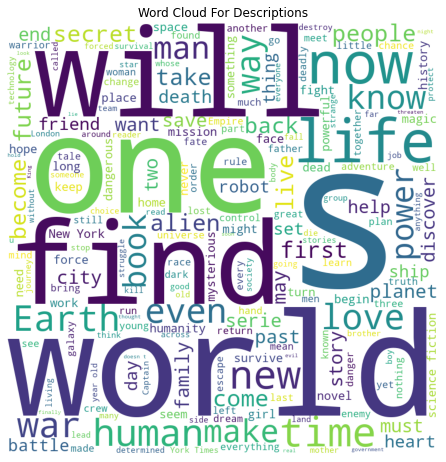

In [38]:
words = ' '.join(list(df_desc['Book_Description']))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

# plot the WordCloud image                       
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title(f'Word Cloud For Descriptions')
plt.show()

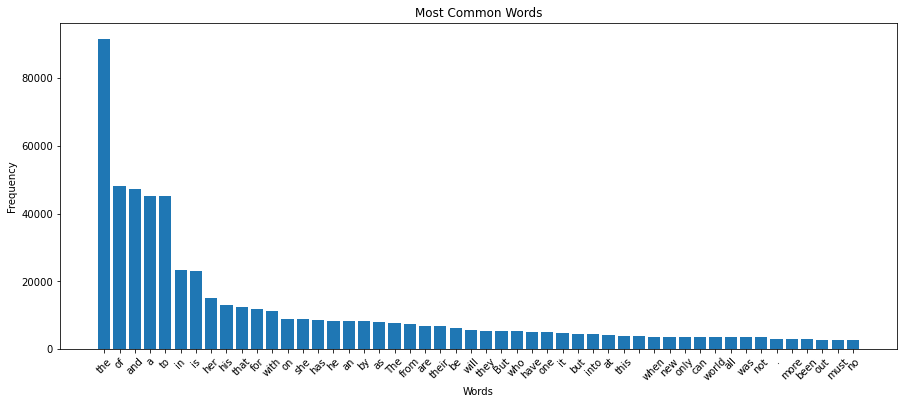

In [39]:
tokens = words.split(' ')

data_freqdist = FreqDist(tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

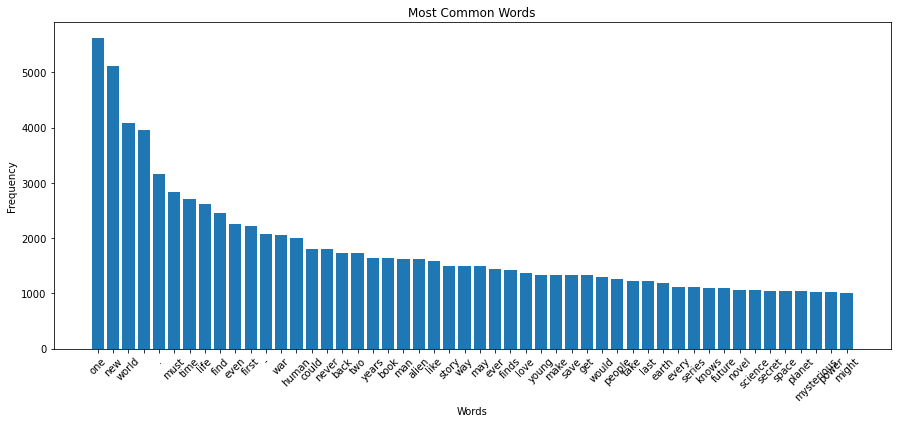

In [40]:
clean_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]

data_freqdist = FreqDist(clean_tokens)

x = []
y = []

for token in data_freqdist.most_common(50):
    x.append(token[0])
    y.append(token[1])

plt.figure(figsize=(15, 6))
plt.bar(x=x, height=y)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.title(f'Most Common Words')
plt.ylabel('Frequency')
plt.show()

In [41]:
test_df = df_desc.sample(n=15)
str(test_df['Book_Description'])

'8330     Norby the robot and his friend Jeff travel to ...\n3621     The end of the world didn’t happen overnight.A...\n8924     As a corrupt Commonwealth rules the galaxy thr...\n1429     WAR IS HELL... It is 1918 and Graf von Dracula...\n10745    Die 17-jährige Anna verbringt ihre Sommerferie...\n3413     The Zombie Survival Guide is your key to survi...\n6203     "One of the best long-running SF series in exi...\n5792     Furnace Prison ...Where death is the least of ...\n7902     Shipwrecked on a remote, wild island, Robot Ro...\n1375     Ginger Stuyvesant, an American heiress living ...\n10373    TEXAS, PRESENT DAY. Ellie Denton\'s world has s...\n159      It was a dark and stormy night.Out of this wil...\n7829     Paul Taylor is in his last year of high school...\n6118     Librarian\'s Note: an alternate cover for this ...\n2703     Calvin Summers and Ethan Hobbs have been best ...\nName: Book_Description, dtype: object'

In [42]:
x = test_df['Book_Description'].iloc[0]

In [43]:
x

'Norby the robot and his friend Jeff travel to the distant planet of Izz and help to rescue a lost princess.'

In [44]:
doc = nlp(x)

In [45]:
doc.ents

(Jeff, Izz)

In [46]:
y = test_df['Book_Description'].iloc[1]

In [47]:
y

'The end of the world didn’t happen overnight.After years of societal breakdowns, wars and quakes and rising tides, humanity was already near the edge. Then came a final blow no one could have expected: all the world’s corpses rising up to make more.Born into this bleak and bloody landscape, twelve-year-old Julie struggles to hold on to hope as she and her parents drive across the wastelands of America, a nightmarish road trip in search of a new home.Hungry, lost, and scared, sixteen-year-old Nora finds herself her brother’s sole guardian after her parents abandon them in the not-quite-empty ruins of Seattle.And in the darkness of a forest, a dead man opens his eyes. Who is he? What is he? With no clues beyond a red tie and the letter “R,” he must unravel the grim mystery of his existence—right after he learns how to think, how to walk, and how to satisfy the monster howling in his belly. The New Hunger is a glimpse of the past and a path to an astonishing future…'

In [48]:
doc_2 = nlp(y)

In [49]:
doc_2.ents[-2]

Seattle

In [50]:
z = test_df['Book_Description'].iloc[2]
z

'As a corrupt Commonwealth rules the galaxy through the might of its armies, its most influential general--a renegade Guardian of the deposed Starfire royal line--pursues the rumor of a hidden heir to the throne and searches for a woman he loves and is destined to destroy.From the Trade Paperback edition.'

In [51]:
doc_3 = nlp(z)

In [52]:
doc_3.ents

(Commonwealth, Guardian, Starfire)

In [53]:
df_desc[df_desc['Rating_votes'] == 0]

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,...,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel
6396,This Shoal of Space,\n 074330084X\n ...,John Argo,English,0.0,0,0,"A complex, imaginative SF tale set in a small ...",2000,{'None': 1000},...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8694,We Have Always Been Here,\n 0756417295\n ...,Lena Nguyen,English,0.0,0,1,This psychological sci-fi thriller from a debu...,2021,"{'Science Fiction': 5, 'Adult': 2}",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
df_desc.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel'],
      dtype='object')

In [55]:
len(df_desc)

11025

In [56]:
df_desc['Author_Name'].nunique()

3959

In [57]:
len(df_desc[df_desc['Year_published'] == 0])

27

In [58]:
pd.options.display.max_columns=50
pd.options.display.max_rows=1000

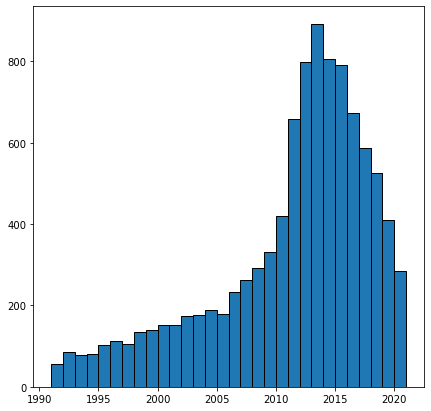

In [59]:
x = df_desc[df_desc['Year_published'] > 1990]['Year_published']
plt.figure(figsize=(7,7))
plt.hist(x=x, bins=30, edgecolor='black')
plt.show()

## Process Text

Figure out which number book this is in the author's career on this list.

Version 1:
- TF-IDF
- Play with SpaCy Pipe options
- Entity Recognition?
- Language Recognition

Objective 1:
- SVM
- Keras?
- K 



In [60]:
def number_genres(x):
    
    answer = 0
    
    for genre in genre_list:
        answer += x[f'{genre}']
    
    return answer

In [61]:
df_desc['Num_Genres'] = df_desc.apply(number_genres, axis=1)

In [62]:
df_desc['Num_Genres'].value_counts()

1.0    8475
2.0    1730
3.0     530
4.0     176
5.0      64
6.0      29
7.0      12
8.0       8
9.0       1
Name: Num_Genres, dtype: int64

In [63]:
df_desc[df_desc['Num_Genres'] == 9]

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
15,The Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy,Douglas Adams,English,4.22,1484282,31208,Seconds before the Earth is demolished to make...,1979,"{'Science Fiction': 14431, 'Fiction': 10469, '...",https://www.goodreads.com/book/show/386162.The...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,9.0


In [64]:
df_desc['Review_number'].describe()

count     11025.000000
mean       1355.155193
std        5403.296914
min           0.000000
25%          55.000000
50%         163.000000
75%         597.000000
max      174079.000000
Name: Review_number, dtype: float64

In [65]:
df_desc[df_desc['Review_number'] > 100000]

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
1536,The Hunger Games,The Hunger Games,Suzanne Collins,English,4.33,6572148,174079,"Could you survive on your own in the wild, wit...",2008,"{'Young Adult': 31089, 'Fiction': 17571, 'Scie...",https://www.goodreads.com/book/show/2767052-th...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
1839,Mockingjay,Mockingjay,Suzanne Collins,English,4.00,2012173,101751,My name is Katniss Everdeen.Why am I not dead?...,2010,"{'Young Adult': 24917, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/7260188-mo...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2005,Divergent,Divergent,Veronica Roth,English,4.19,3008156,109103,"In Beatrice Prior's dystopian Chicago world, s...",2011,"{'Young Adult': 20861, 'Science Fiction (Dysto...",https://www.goodreads.com/book/show/13335037-d...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2540,Harry Potter and the Sorcerer's Stone,Harry Potter and the Philosopher's Stone,J.K. Rowling,English,4.48,7336299,116268,Harry Potter's life is miserable. His parents ...,1997,"{'Fantasy': 63272, 'Fiction': 18715, 'Young Ad...",https://www.goodreads.com/book/show/3.Harry_Po...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [66]:
z = df_desc['Genres'].iloc[0]

In [67]:
z

"{'Young Adult': 3439, 'Fantasy (Paranormal) ': 2652, 'Fantasy': 2545, 'Romance': 2507, 'Science Fiction (Aliens) ': 1648, 'Science Fiction': 1170, 'Romance (Paranormal Romance) ': 849, 'Fantasy (Supernatural) ': 494, 'Fantasy (Urban Fantasy) ': 411, 'Fiction': 347}"

In [68]:
z.replace('{','')

"'Young Adult': 3439, 'Fantasy (Paranormal) ': 2652, 'Fantasy': 2545, 'Romance': 2507, 'Science Fiction (Aliens) ': 1648, 'Science Fiction': 1170, 'Romance (Paranormal Romance) ': 849, 'Fantasy (Supernatural) ': 494, 'Fantasy (Urban Fantasy) ': 411, 'Fiction': 347}"

In [69]:
z.split("'")

['{',
 'Young Adult',
 ': 3439, ',
 'Fantasy (Paranormal) ',
 ': 2652, ',
 'Fantasy',
 ': 2545, ',
 'Romance',
 ': 2507, ',
 'Science Fiction (Aliens) ',
 ': 1648, ',
 'Science Fiction',
 ': 1170, ',
 'Romance (Paranormal Romance) ',
 ': 849, ',
 'Fantasy (Supernatural) ',
 ': 494, ',
 'Fantasy (Urban Fantasy) ',
 ': 411, ',
 'Fiction',
 ': 347}']

In [70]:
def find_genre(entry):

    split = entry.split("'")

    genres = []

    for n in range(len(split)):
        if n%2==1:
            genres.append(split[n])

    return genres

In [71]:
df_desc['genres'] = df_desc['Genres'].map(lambda x: find_genre(x))

In [72]:
df_desc['genres']

0        [Young Adult, Fantasy (Paranormal) , Fantasy, ...
1        [Young Adult, Fantasy (Paranormal) , Romance, ...
2        [Young Adult, Science Fiction, Science Fiction...
3        [Young Adult, Science Fiction, Fantasy, Romanc...
4        [Young Adult, Fantasy (Paranormal) , Romance, ...
                               ...                        
11090    [Romance (Historical Romance) , Science Fictio...
11091    [Fantasy, Childrens, Fiction, Historical (Hist...
11092    [Romance, Science Fiction (Time Travel) , Roma...
11093    [Fiction, Historical (Historical Fiction) , No...
11094    [Fantasy, Fiction, Childrens, Childrens (Middl...
Name: genres, Length: 11025, dtype: object

In [73]:
lst = []

for x in df_desc['genres']:
    lst.extend(x)

unique_list = set(lst)

In [74]:
len(unique_list)

523

In [75]:
def age_group(x):

    if 'Children' in x:
        return 'Children'
    elif 'Young Adult' in x:
        return 'Young Adult'
    else:
        return 'Adult'

In [76]:
df_desc['Age_Group'] = df_desc['Genres'].map(lambda x: age_group(x))

In [77]:
df_desc['Age_Group'].value_counts(normalize=True)

Adult          0.727619
Young Adult    0.199637
Children       0.072744
Name: Age_Group, dtype: float64

In [78]:
labeler = LabelEncoder()

In [79]:
df_desc.columns

Index(['Book_Title', 'Original_Book_Title', 'Author_Name', 'Edition_Language',
       'Rating_score', 'Rating_votes', 'Review_number', 'Book_Description',
       'Year_published', 'Genres', 'url', 'aliens', 'alternate_history',
       'alternate_universe', 'apocalyptic', 'cyberpunk', 'dystopia', 'hard',
       'military', 'robots', 'space_opera', 'steampunk', 'time_travel',
       'Num_Genres', 'genres', 'Age_Group'],
      dtype='object')

## Model 1: Age Group

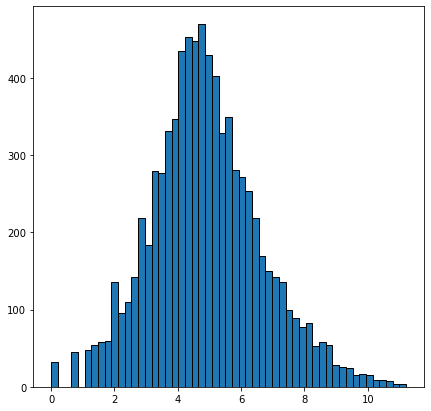

In [80]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [81]:
df_desc[df_desc['Age_Group'] == 'Adult'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,8022.000000,8.022000e+03,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000,8022.000000
mean,3.926234,1.520380e+04,803.499252,2001.084144,0.119920,0.119172,0.077911,0.101970,0.137871,0.054226,0.142359,0.151085,0.088631,0.136998,0.094490,0.104961,1.329594
std,0.298510,9.859334e+04,3391.949178,98.948937,0.324888,0.324011,0.268048,0.302627,0.344786,0.226477,0.349439,0.358154,0.284228,0.343867,0.292528,0.306523,0.751888
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.730000,5.592500e+02,43.000000,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.940000,1.575000e+03,115.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.140000,4.908750e+03,375.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,3.276673e+06,73943.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


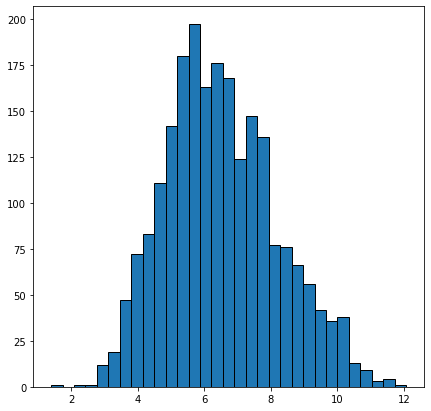

In [82]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Young Adult']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [83]:
df_desc[df_desc['Age_Group'] == 'Young Adult'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,2201.000000,2.201000e+03,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,3.913285,4.309569e+04,3035.430713,2006.315766,0.098137,0.108587,0.207633,0.185370,0.050432,0.341663,0.030441,0.016356,0.088142,0.058155,0.182190,0.125398,1.492503
std,0.292804,2.139555e+05,8657.940568,105.193548,0.297568,0.311191,0.405705,0.388686,0.218884,0.474375,0.171836,0.126870,0.283565,0.234090,0.386089,0.331244,0.933256
min,2.500000,9.000000e+00,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.720000,1.663000e+03,201.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.900000,5.003000e+03,578.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.120000,1.846300e+04,2024.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,4.820000,6.572148e+06,174079.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


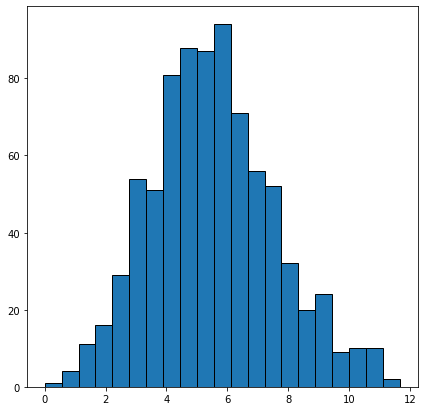

In [84]:
y = [np.log1p(x) for x in df_desc[df_desc['Age_Group'] == 'Children']['Review_number']]
plt.figure(figsize=(7,7))
plt.hist(y, bins='auto', edgecolor='black')
plt.show()

In [85]:
df_desc[df_desc['Age_Group'] == 'Children'].describe()

,Rating_score,Rating_votes,Review_number,Year_published,aliens,alternate_history,alternate_universe,apocalyptic,cyberpunk,dystopia,hard,military,robots,space_opera,steampunk,time_travel,Num_Genres
count,802.000000,8.020000e+02,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,3.927045,7.731158e+04,2261.760599,1999.273067,0.087282,0.064838,0.205736,0.022444,0.009975,0.067332,0.009975,0.001247,0.413965,0.007481,0.108479,0.159601,1.158354
std,0.288246,4.036289e+05,8312.096194,101.336593,0.282424,0.246393,0.404490,0.148215,0.099438,0.250752,0.099438,0.035311,0.492850,0.086224,0.311178,0.366464,0.493262
min,2.710000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.780000,4.255000e+02,64.000000,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.940000,2.605000e+03,217.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.120000,1.548650e+04,893.750000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,4.620000,7.336299e+06,116268.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [86]:
import seaborn as sns

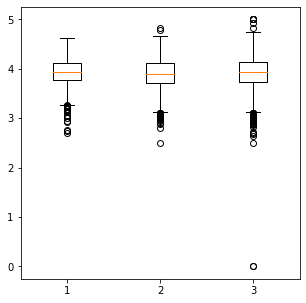

In [87]:
data = []
for age in ['Children','Young Adult','Adult']:
    x = df_desc[df_desc['Age_Group']==age]['Rating_score']
    data.append(x)

fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot(data)
plt.show()


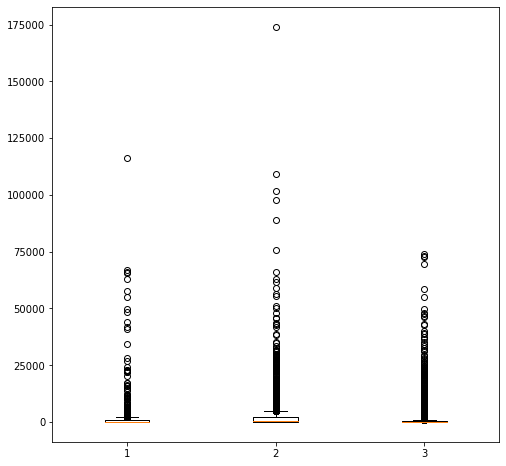

In [88]:
data = []
for age in ['Children','Young Adult','Adult']:
    x = df_desc[df_desc['Age_Group']==age]['Review_number']
    data.append(x)

fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(data)
plt.show()


In [89]:
unique_list

{'40k',
 'Academic',
 'Academic (College) ',
 'Academic (Read For School) ',
 'Academic (School) ',
 'Academic (Teachers) ',
 'Action',
 'Adult',
 'Adult Fiction',
 'Adult Fiction (Erotica) ',
 'Adventure',
 'Adventure (Pirates) ',
 'Adventure (Survival) ',
 'African Literature (Egyptian Literature) ',
 'Aircraft (Airships) ',
 'Alcohol (Cocktails) ',
 'American (Americana) ',
 'American (Southern) ',
 'American History (American Civil War) ',
 'Amish',
 'Animals',
 'Animals (Anthropomorphic) ',
 'Animals (Birds) ',
 'Animals (Cats) ',
 'Animals (Dinosaurs) ',
 'Animals (Dogs) ',
 'Animals (Horses) ',
 'Animals (Rabbits) ',
 'Animals (Wolves) ',
 'Anthologies',
 'Anthologies (Collections) ',
 'Anthropology',
 'Apocalyptic (Post Apocalyptic) ',
 'Art',
 'Art (Art Design) ',
 'Art (Crafts) ',
 'Art and Photography',
 'Artificial Intelligence',
 'Asian Literature (Chinese Literature) ',
 'Asian Literature (Japanese Literature) ',
 'Astronomy (Planets) ',
 'Audiobook',
 'Autobiography (Mem

In [90]:
spacy_1 = TextSet(X=df_desc['Book_Description'],
                  y=df_desc['Age_Group'],
                  name = 'SpaCy 1',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42)

--- 7809.9646089077 seconds ---


In [91]:
tf_idf = TextSet(X=df_desc['Book_Description'],
                 y=df_desc['Age_Group'],
                 name='tf-idf_1',
                 is_spacy=False, 
                 keep_stopwords=False)

--- 9314.056342124939 seconds ---


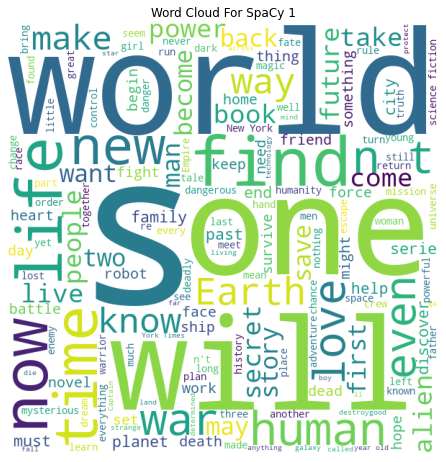

In [92]:
spacy_1.word_cloud()

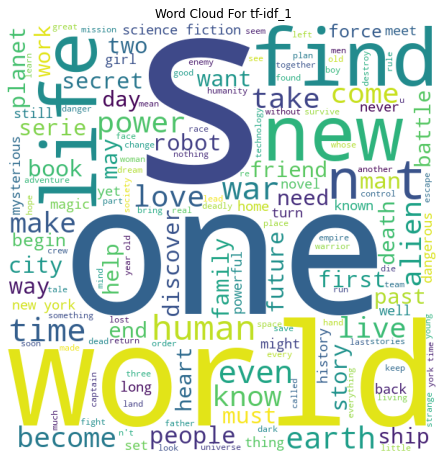

In [93]:
tf_idf.word_cloud()

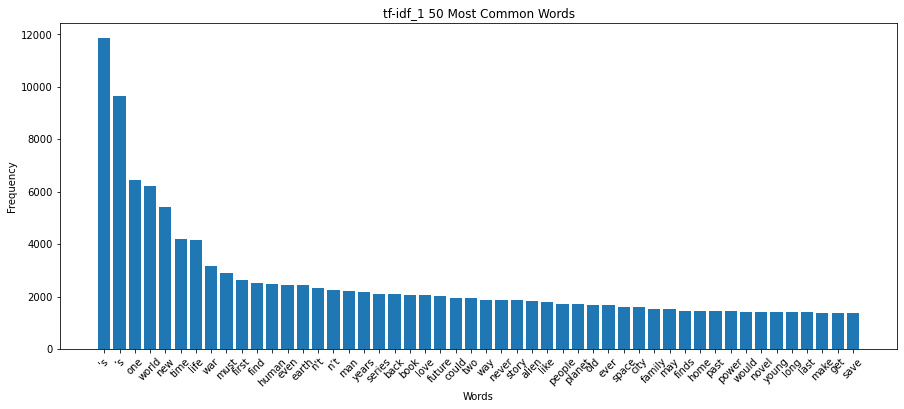

In [94]:
tf_idf.plot_frequency()

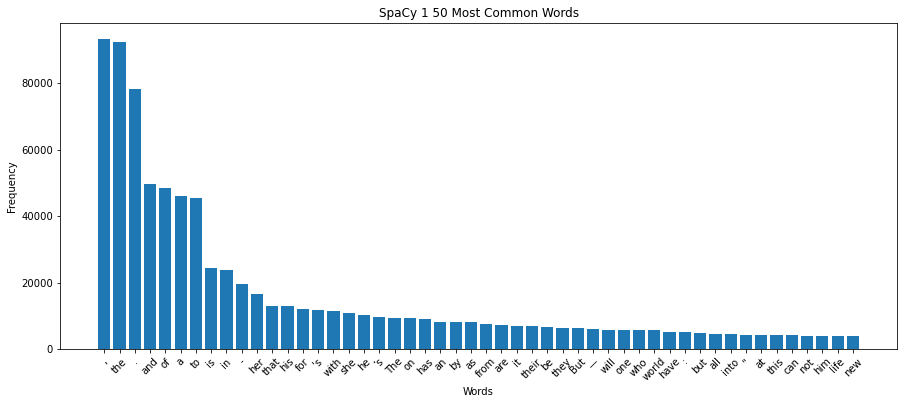

In [95]:
spacy_1.plot_frequency()

In [96]:
spacy_1.vectorize()
tf_idf.vectorize()

In [97]:
data = [spacy_1, tf_idf]

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [99]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf',svm.SVC())])

grid= {
    'rbf__kernel':['rbf','sigmoid'],
#     'rbf__gamma' :['scale','auto'],
    'rbf__C': [1, 1e12],
#     'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy',cv=5)
svm_compare = ModelComparison(pipeline=svm_grid, data_list=data, y_format='label',name='svm')

In [ ]:
svm_compare.fit_models()
svm_compare.score_comparison
svm_compare.pipeline.best_params_

In [ ]:
svm_compare_2 = ModelComparison(pipeline=svm_pipe, data_list=data, y_format='label',name='svm')
svm_compare_2.fit_models()
svm_compare_2.score_comparison